In [41]:
# Общий достп
# https://colab.research.google.com/drive/1yPwDizq1A621wbQ-VUfIW62hLvh6INba#scrollTo=zrsjO8ERfriF
# Файлы все равно надо загружать

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
import psycopg2
import psycopg2.extras

import matplotlib.pyplot as plt

import io
import datetime
import joblib
import json
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



In [17]:
# PATH + '/data/' - обеспечить входные файлы
# PATH + /checkpoint/ - обеспечить файл с весами модели
PATH = '/content/drive/MyDrive/Colab Notebooks/hack30112024/'
SERIES_LENGTH = 64

In [3]:
files = []

for file_it in range(1, 6):
    f = pd.read_csv(PATH + 'input/data' + str(file_it) + '.csv')['value'].to_numpy().astype(np.float32).reshape(-1, 1)
    f = np.nan_to_num(f)

    files += [f]

In [4]:
prep_rows = np.concatenate(files)
scaler = MinMaxScaler().fit(prep_rows)
sc_rows = scaler.transform(prep_rows)

In [5]:
prep_rows.max(), prep_rows.min(), sc_rows.max(), sc_rows.min()

(7713.0, 0.0, 1.0, 0.0)

In [18]:

def transform(rows):
    X, y = [], []

    rows = scaler.transform(rows)

    for it in range(SERIES_LENGTH, len(rows)):

        X.append(rows[it - SERIES_LENGTH : it])
        y.append(rows[it])

    return X, y


X_train, X_test, y_train, y_test = [], [], [], []
files_data = []

for file in files:

    rows = file[:, 0 : 1]

    X_, y_ = transform(rows)

    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.10, random_state=42, shuffle=False)

    X_train += X_train_
    X_test += X_test_
    y_train += y_train_
    y_test += y_test_

    files_data += [{'X_train': X_train_, 'X_test': X_test_, 'y_train': y_train_, 'y_test': y_test_}]



X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3518, 64, 1), (3518, 1), (392, 64, 1), (392, 1))

In [19]:

inputs = keras.layers.Input(shape=X_train.shape[1:])

hide = keras.layers.LSTM(64, return_sequences=True)(inputs)
hide = keras.layers.LSTM(64, return_sequences=False)(hide)

outputs = keras.layers.Dense(y_train.shape[-1], activation=keras.activations.sigmoid)(hide)

model = keras.Model(inputs=inputs, outputs=outputs, name='')
model.summary()


Model: ""

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:

def metric_abs(y_true, y_pred):
    return tf.math.abs(1.0 - y_true / y_pred)

def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(keras.losses.mean_squared_error(y_true, y_pred))

model.compile(optimizer=keras.optimizers.Adam(0.01), loss=metric_abs, metrics=[keras.losses.mean_absolute_error, root_mean_squared_error])

es_callback = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=PATH + "checkpoint/model_3.weights.h5",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

try:
    model.load_weights(modelckpt_callback.filepath)
except:
    pass

In [32]:

history = model.fit(
    X_train, y_train,
    epochs=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[es_callback, modelckpt_callback],
    batch_size=30
)

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0694 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0065
Epoch 1: loss improved from inf to 0.06930, saving model to /content/drive/MyDrive/Colab Notebooks/hack30112024/checkpoint/model_3.weights.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 0.0694 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0065 - val_loss: 0.1533 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0140


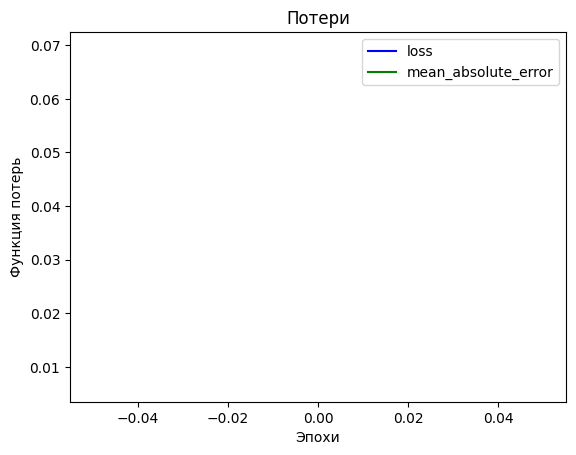

In [33]:
loss = history.history["loss"][::2]
metric_abs = history.history["mean_absolute_error"][::2]

epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="loss")
plt.plot(epochs, metric_abs, "g", label="mean_absolute_error")
plt.title("Потери")
plt.xlabel("Эпохи")
plt.ylabel("Функция потерь")
plt.legend()
plt.show()

In [34]:
model.load_weights(modelckpt_callback.filepath)

In [35]:
def predict_next(rows, count):
    X = scaler.transform(rows[ - SERIES_LENGTH :])
    result = []

    for it in range(count):

        new_row = model.predict(X.reshape(1, -1, 1), verbose=0)[0]

        result.append(new_row)

        X = np.concatenate([X[1 :], [new_row]])

    if len(result) != 0:
        result = scaler.inverse_transform(result)

    return np.array(result)


In [36]:
model.evaluate(X_train, y_train)

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0545 - mean_absolute_error: 0.0095 - root_mean_squared_error: 0.0095


[0.0651020035147667, 0.006457136012613773, 0.006457136012613773]

In [37]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1397 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0186


[0.1532631665468216, 0.01399613544344902, 0.01399613544344902]

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


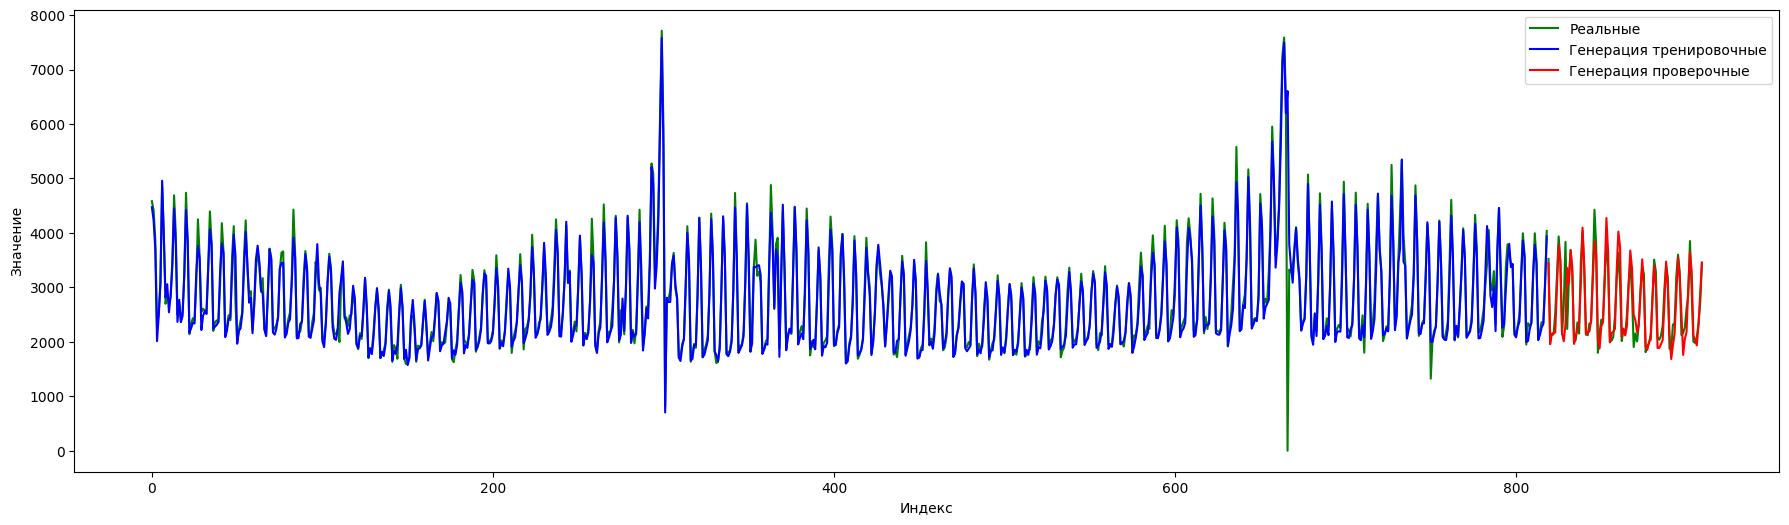

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


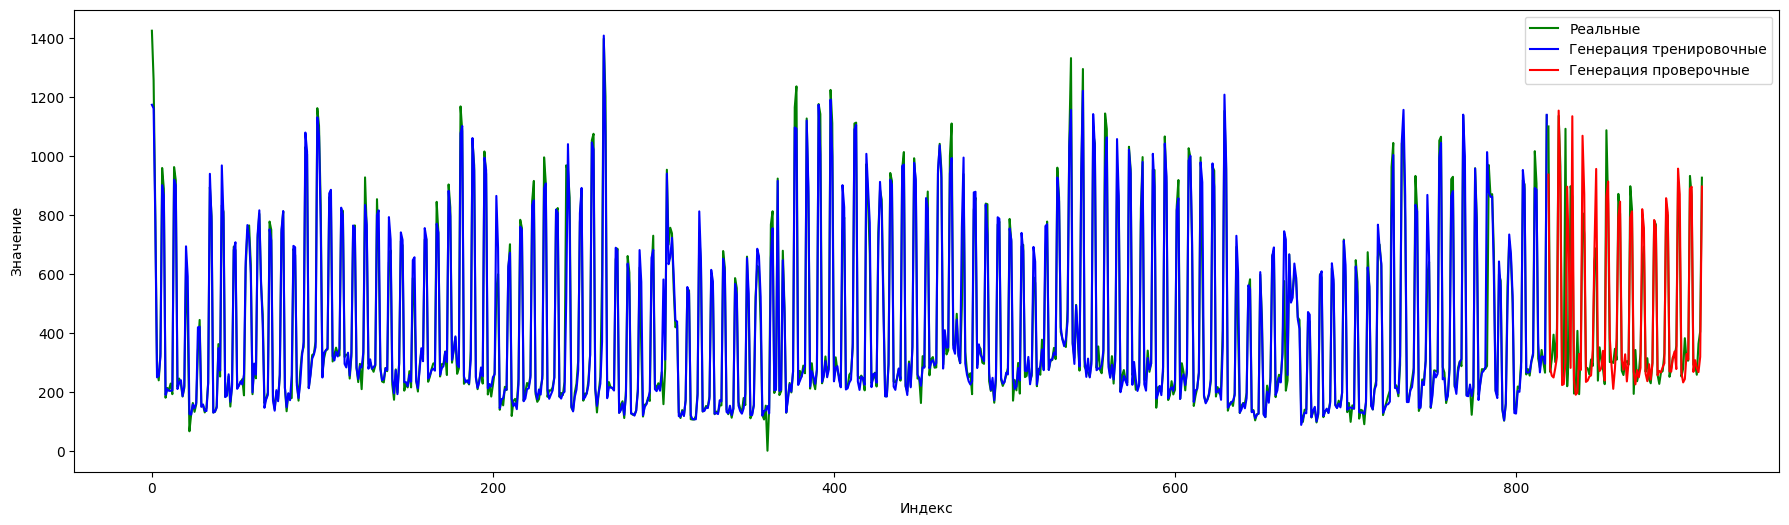

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


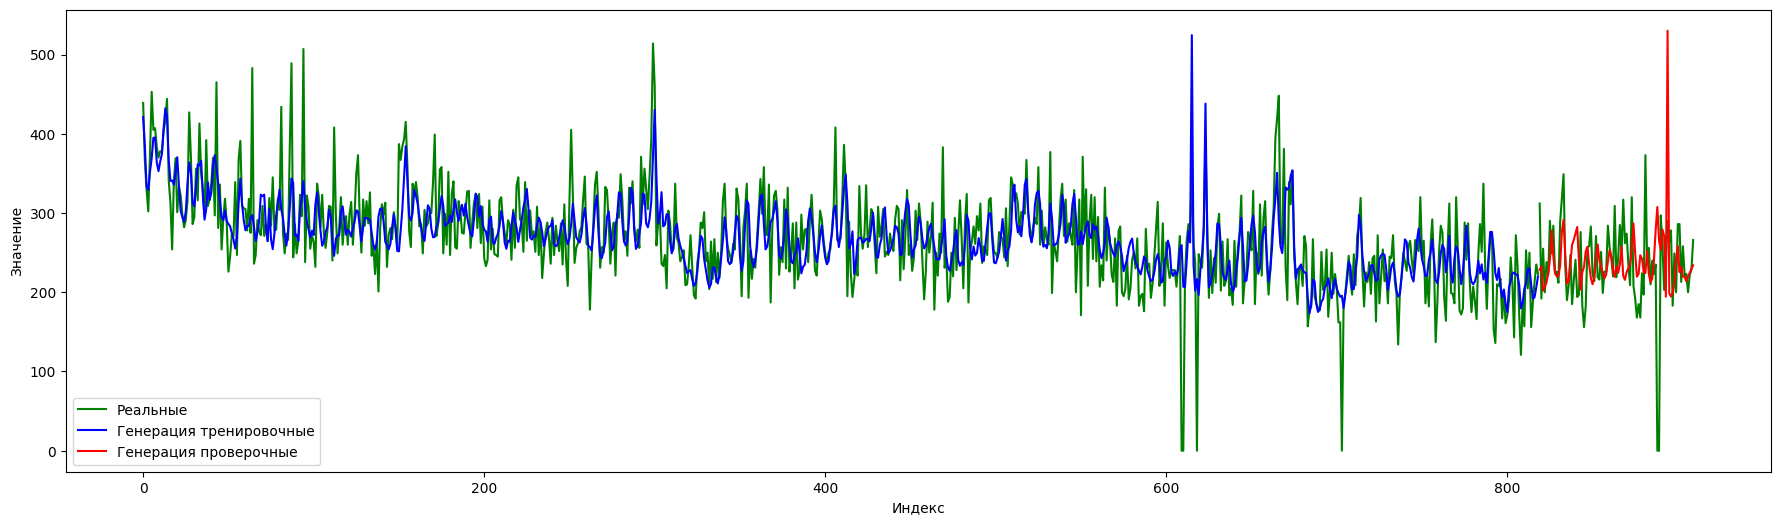

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


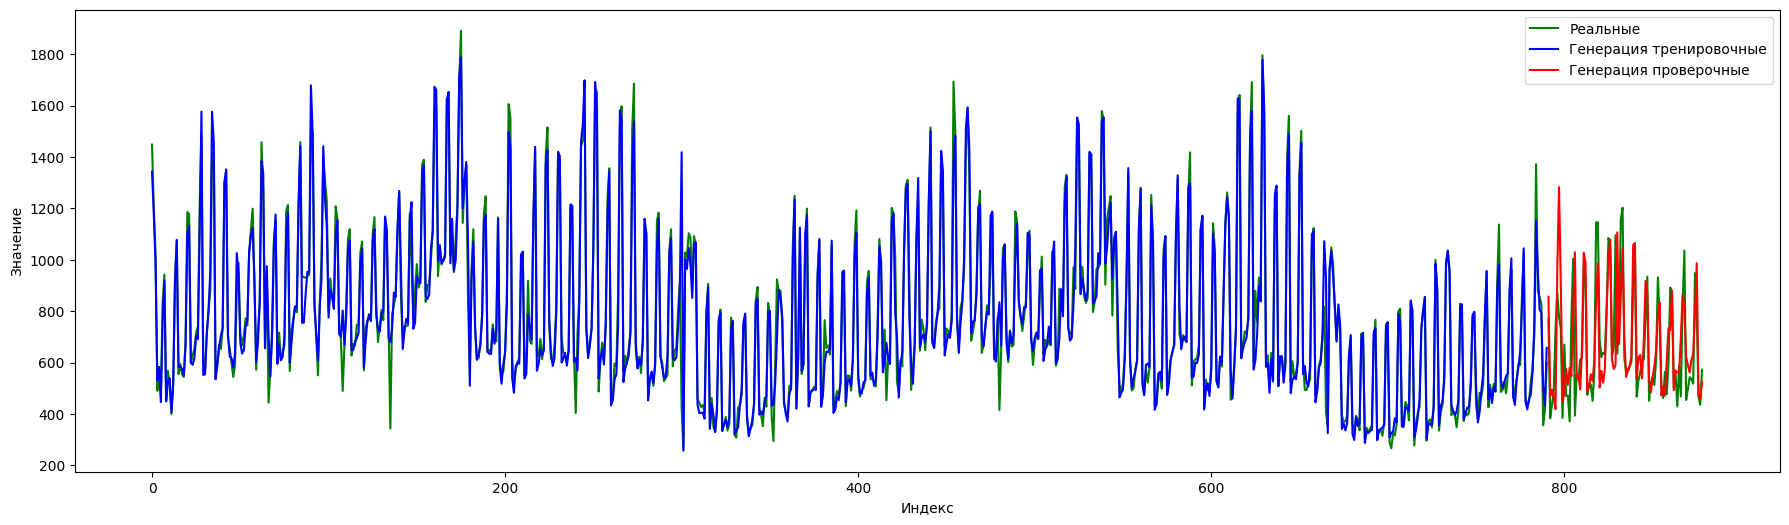

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


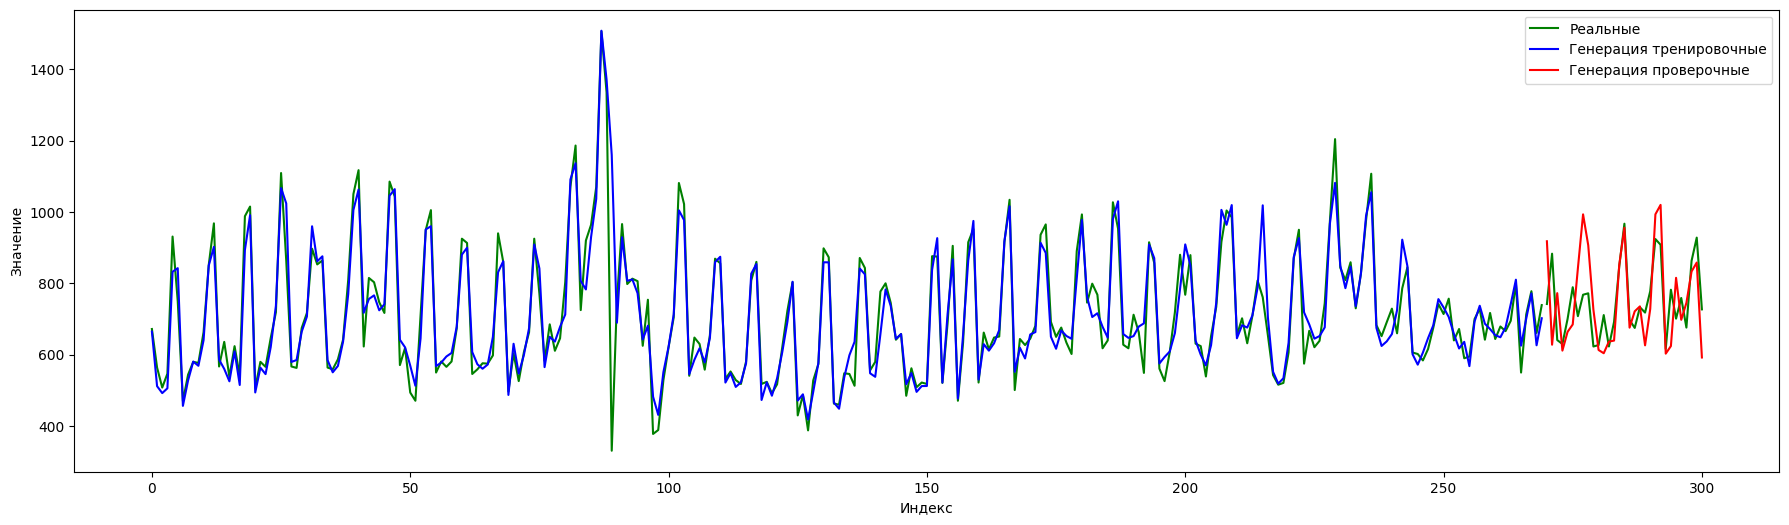

In [38]:
for file in files_data:

    X_train_ = file['X_train']
    y_train_ = scaler.inverse_transform(file['y_train'])
    y_train_pred_ = scaler.inverse_transform(model.predict(np.array(X_train_)))

    X_test_ = file['X_test']
    y_test_ = scaler.inverse_transform(file['y_test'])
    y_test_pred_ = scaler.inverse_transform(model.predict(np.array(X_test_)))

    plt.figure(figsize=(22, 6))
    plt.plot(range(len(y_train_)), y_train_[:, 0], color='green', label='Реальные')
    plt.plot(range(len(y_train_pred_)), y_train_pred_[:, 0], color='blue', label='Генерация тренировочные')

    plt.plot(range(len(y_train_), len(y_train_) + len(y_test_)), y_test_[:, 0], color='green')
    plt.plot(range(len(y_train_pred_), len(y_train_pred_) + len(y_test_pred_)), y_test_pred_[:, 0], color='red', label='Генерация проверочные')


    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0548 - mean_absolute_error: 0.0052 - root_mean_squared_error: 0.0052
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


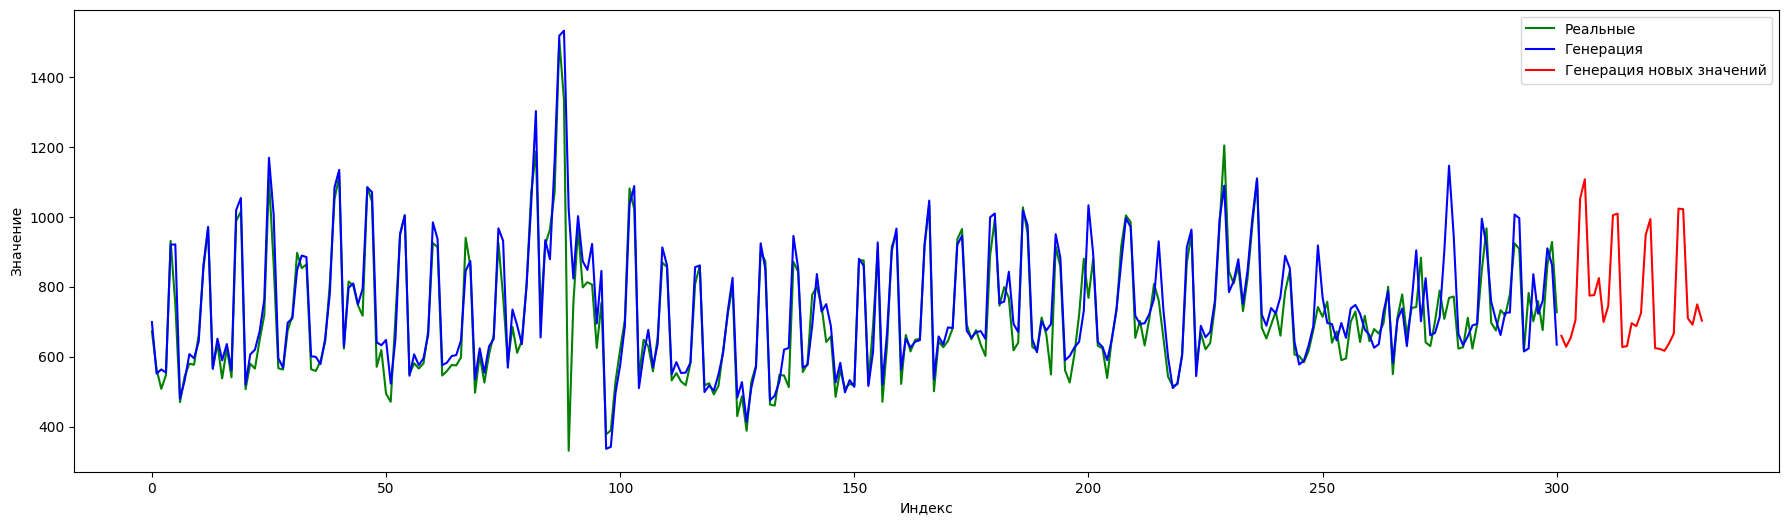

In [39]:
file = files[4]

X, y = transform(file)

X = np.array(X)
y = np.array(y)

model.load_weights(modelckpt_callback.filepath)

model.fit(
    X, y,
    epochs=1,
    shuffle=True,
    callbacks=[es_callback],
    batch_size=30
)


y = scaler.inverse_transform(y)
y_train_pred = scaler.inverse_transform(model.predict(np.array(X)))

y_new = predict_next(file, 31)


plt.figure(figsize=(22, 6))
plt.plot(range(len(y)), y[:, 0], color='green', label='Реальные')
plt.plot(range(len(y_train_pred)), y_train_pred[:, 0], color='blue', label='Генерация')

plt.plot(range(len(y_train_pred), len(y_train_pred) + len(y_new)), y_new[:, 0], color='red', label='Генерация новых значений')


plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()